# Working on self-drive car sentiments

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

In [0]:
# For evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [7]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('sentiment_self_drive.pkl')
df.shape

(6943, 2)

In [8]:
df.head()

,text,sent_numeric
0,Two places I'd invest all my money if I could:...,Positive
1,Awesome! Google driverless cars will help the ...,Positive
2,If Google maps can't keep up with road constru...,Negative
3,Autonomous cars seem way overhyped given the t...,Negative
4,Just saw Google self-driving car on I-34. It w...,Neutral


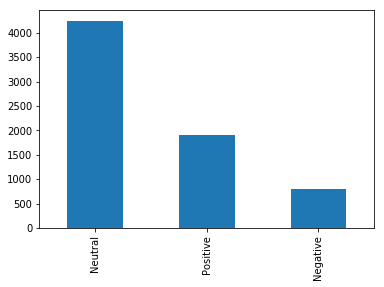

In [9]:
df.sent_numeric.value_counts().plot(kind='bar')

## Using only positive and negative sentiments

In [0]:
df=df[df.sent_numeric!= "Neutral"]

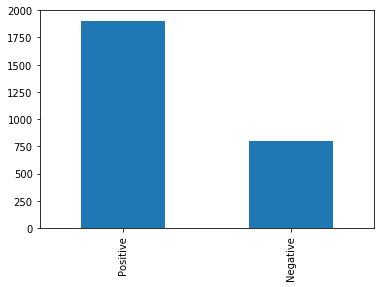

In [11]:
df.sent_numeric.value_counts().plot(kind='bar')

In [12]:
df.shape

(2698, 2)

## Label the categorical values

In [0]:
df['labels'] = df.sent_numeric.map({'Negative':0, 'Positive':1})

In [14]:
df.head()

,text,sent_numeric,labels
0,Two places I'd invest all my money if I could:...,Positive,1
1,Awesome! Google driverless cars will help the ...,Positive,1
2,If Google maps can't keep up with road constru...,Negative,0
3,Autonomous cars seem way overhyped given the t...,Negative,0
8,Autonomous vehicles could reduce traffic fatal...,Positive,1


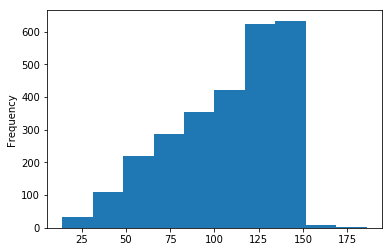

In [15]:
df['text'].str.len().plot.hist()

# Cleaning

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [0]:
df['cleaned']=[text_prepare(x) for x in df['text']]

In [18]:
print(df.text[:5])

0    Two places I'd invest all my money if I could:...
1    Awesome! Google driverless cars will help the ...
2    If Google maps can't keep up with road constru...
3    Autonomous cars seem way overhyped given the t...
8    Autonomous vehicles could reduce traffic fatal...
Name: text, dtype: object


In [19]:
df.cleaned[:5]

0    two places id invest money could 3d printing s...
1    awesome google driverless cars help blind trav...
2    google maps cant keep road construction suppos...
3    autonomous cars seem way overhyped given techn...
8    autonomous vehicles could reduce traffic fatal...
Name: cleaned, dtype: object

### most common words

In [20]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('car', 1367),
 ('cars', 1345),
 ('tco', 1090),
 ('selfdriving', 1004),
 ('google', 928),
 ('driving', 804),
 ('driverless', 713),
 ('self', 670),
 ('googles', 243),
 ('cant', 155)]

### Splitting data
Split X and y into training and testing sets

In [0]:
X=df['cleaned']
y=df['labels']

In [22]:
X.head()

0    two places id invest money could 3d printing s...
1    awesome google driverless cars help blind trav...
2    google maps cant keep road construction suppos...
3    autonomous cars seem way overhyped given techn...
8    autonomous vehicles could reduce traffic fatal...
Name: cleaned, dtype: object

In [23]:
y[:5]

0    1
1    1
2    0
3    0
8    1
Name: labels, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2023,)
(675,)
(2023,)
(675,)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Only Transform the test sets 
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
    
    
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)

In [0]:
# convert to dense array
X_train_tfidf=X_train_tfidf.toarray()

In [27]:
type(X_train_tfidf)

numpy.ndarray

In [0]:
X_test_tfidf=X_test_tfidf.toarray()

In [29]:
y_train[:5]

3948    1
1312    0
3191    1
701     1
2752    1
Name: labels, dtype: int64

# 4)- LSTM

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [40]:
df.head()

,text,sent_numeric,labels,cleaned
0,Two places I'd invest all my money if I could:...,Positive,1,two places id invest money could 3d printing s...
1,Awesome! Google driverless cars will help the ...,Positive,1,awesome google driverless cars help blind trav...
2,If Google maps can't keep up with road constru...,Negative,0,google maps cant keep road construction suppos...
3,Autonomous cars seem way overhyped given the t...,Negative,0,autonomous cars seem way overhyped given techn...
8,Autonomous vehicles could reduce traffic fatal...,Positive,1,autonomous vehicles could reduce traffic fatal...


In [0]:
Y=df['sent_numeric']

In [0]:
y_train, y_test = train_test_split(Y, random_state=2019)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2019)

In [43]:
print(y_train.shape)
print(y_test.shape)


(2023,)
(675,)


In [44]:
y_train[:5]

5487    Positive
6047    Positive
3494    Positive
1195    Negative
1394    Positive
Name: sent_numeric, dtype: object

In [45]:
y_test[:5]

5230    Positive
3619    Positive
1321    Negative
5447    Positive
1997    Positive
Name: sent_numeric, dtype: object

In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [47]:
y_train_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [48]:
y_test_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [64]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(2023, 2)
(675, 2)


**This step shows that we have two output. So our last Dense layer will 2**

In [49]:
df['cleaned'].shape

(2698,)

In [0]:
X=[text_prepare(x) for x in df['cleaned']]

In [51]:
X[:5]

['two places id invest money could 3d printing selfdriving cars',
 'awesome google driverless cars help blind travel often https tco qwuxr0frbpv',
 'google maps cant keep road construction supposed trust driverless car get around',
 'autonomous cars seem way overhyped given technology challenges pilotless planes seem much doable needed',
 'autonomous vehicles could reduce traffic fatalities 90im']

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [53]:
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  126,  461,   90,  819,  210,   22,  505,  820,    4,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   45,    5,    7,    2,  252,  302,  462, 1042,   93,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
         171,   10,  272,   37, 1043, 1044,   99,    7,    1,   17,   63],
       [   0,    0,    0,    0,    0,    0,    0,    0,   19,    2,  506,
          30, 1407,  573,   46,  675,  676,  574,  506,   53, 1408,  273],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   19,   58,   22,  274,   39, 1409]],
      dtype=int32)

In [54]:
X.shape

(2698, 22)

In [0]:
X_train, X_test = train_test_split(X, random_state=2019)

In [56]:
X_train.shape, X_test.shape

((2023, 22), (675, 22))

# Create LSTM model

In [0]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000

### Build model

In [58]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# X.shape[1] refers to 23 columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


### Train model

In [0]:
batch_size = 32
epochs = 20

In [0]:
from keras.callbacks import EarlyStopping

In [61]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 1820 samples, validate on 203 samples
Epoch 1/20
1820/1820 [==============================] - 6s 3ms/step - loss: 0.6112 - acc: 0.7005 - val_loss: 0.6041 - val_acc: 0.6946
Epoch 2/20
1820/1820 [==============================] - 2s 1ms/step - loss: 0.5159 - acc: 0.7390 - val_loss: 0.5175 - val_acc: 0.7291
Epoch 3/20
1820/1820 [==============================] - 2s 1ms/step - loss: 0.3555 - acc: 0.8544 - val_loss: 0.5741 - val_acc: 0.7537
Epoch 4/20
1820/1820 [==============================] - 2s 1ms/step - loss: 0.2588 - acc: 0.9033 - val_loss: 0.5698 - val_acc: 0.7340
Epoch 5/20
1820/1820 [==============================] - 2s 1ms/step - loss: 0.1845 - acc: 0.9319 - val_loss: 0.6205 - val_acc: 0.7537


# Model Evaluation

In [0]:
# predict probabilities for test set
y_pred = model.predict(X_test)

In [63]:
y_pred[:5]

array([[9.70123112e-01, 2.98768487e-02],
       [7.90762133e-04, 9.99209225e-01],
       [4.89282370e-01, 5.10717571e-01],
       [5.62044442e-01, 4.37955528e-01],
       [1.11643694e-01, 8.88356268e-01]], dtype=float32)

**This is probabilities of our output. We need to convert to crisp classes.**

In [0]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model.predict_classes(X_test, verbose=0)

In [67]:
yhat_classes[:5]

array([0, 1, 1, 0, 1])

In [68]:
y_test_ohe[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [0]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [70]:
y_test_class[:5]

array([1, 1, 0, 1, 1])

In [71]:
y_pred_class[:5]

array([0, 1, 1, 0, 1])

### Classification Report

In [72]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.52      0.47      0.49       202
           1       0.78      0.82      0.80       473

    accuracy                           0.71       675
   macro avg       0.65      0.64      0.64       675
weighted avg       0.70      0.71      0.71       675



## Confusion Matrix

In [73]:
print(confusion_matrix(y_test_class,y_pred_class))

[[ 94 108]
 [ 87 386]]


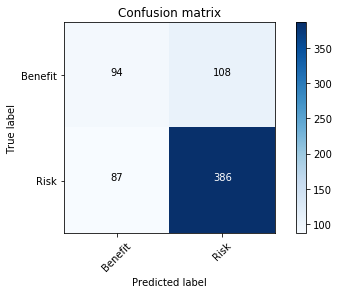

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(cm, classes=['Benefit', 'Risk'])

## Accuracy and loss function

In [75]:
# for training set
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9348
Training Loss: 0.1900


In [76]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.7111
Testing Loss:  0.7108


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

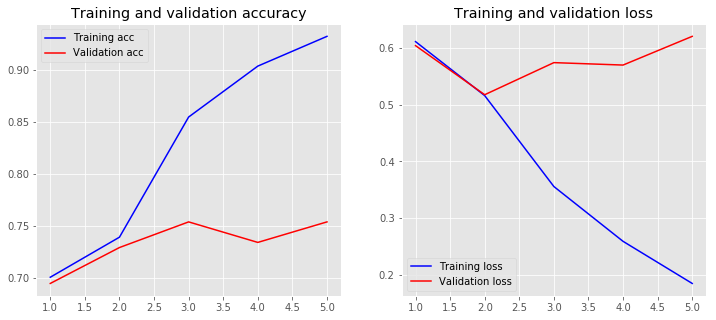

In [78]:
plot_history(history)

In [0]:
#[print(df['text'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]

# Using 1-D LSTM

In [0]:
y=df['labels']

### a)-Accuracy

(tp + tn) / (p + n)

In [0]:
y=df['labels']

In [0]:
y_train, y_test = train_test_split(y, random_state=2019)

In [101]:
y_test[:5]

5230    1
3619    1
1321    0
5447    1
1997    1
Name: labels, dtype: int64

In [105]:
yhat_classes[:5]

array([0, 1, 1, 0, 1])

In [102]:
y_test_class[:5]

array([1, 1, 0, 1, 1])

In [106]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.711111


### Precision: 

tp / (tp + fp)

In [0]:
precision = precision_score(y_test, yhat_classes)

In [109]:
precision

0.7813765182186235

### recall: 

tp / (tp + fn)

In [110]:
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)

Recall: 0.816068


### f1:

2 tp / (2 tp + fp + fn)

In [111]:
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

F1 score: 0.798345


### kappa

In [112]:
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.290052
